In [ ]:
### Michelle Kouba
### Housing Classifer


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
os.chdir('/content/drive/My Drive/GitHub/dsc650/dsc650/assignments/assignment05')
!pwd

Mounted at /content/drive
/content/drive/My Drive/GitHub/dsc650/dsc650/assignments/assignment05


In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import metrics
from keras import models
from keras import layers
from keras import losses
from keras import optimizers
from keras.datasets import boston_housing

## Keras Sequential Housing Classifier

In [ ]:
# Building the neural network
# Defining the model (Keras Sequential)
# Function to compile the model because this will happen multiple times
def build_model():
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=input_shape),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)])
    # Compile the model with the optimizer, loss function, and evaluation metric
    model.compile(optimizer='rmsprop',
                  # mean squared error
                  loss='mse',
                  # mean absolute error
                  metrics=['mae'])
    return model


In [ ]:
# Setting up K Fold Validation
# 4 partitions with 100 epochs
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
input_shape=(train_data.shape[1],)

# Randomly split the data into K folds for cross-validation
for i in range(k):
    print(f"Processing fold #{i}")

    # Preparing the validation data for each fold
    val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples]

    # Preparing  the training data for each fold
    partial_train_data = np.concatenate(
        [train_data[:i*num_val_samples],
         train_data[(i+1)*num_val_samples:]],
        axis=0)

    # Preparing the targets for each fold
    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
         train_targets[(i+1)*num_val_samples:]],
        axis=0)

    # Building the Keras model
    model = build_model()

    # Training the model on the training data for this fold (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)

    # Evaluating the model on the validation data for this fold
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)


Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [ ]:
print('The validation Mean Absolute Error for each of the folds is:', all_scores)

The validation Mean Absolute Error for each of the folds is: [2.5881595611572266, 2.4235780239105225, 2.7142324447631836, 2.198030710220337]


In [ ]:
print('The average MAE is', np.mean(all_scores))

The average MAE is 2.4810001850128174


In [ ]:
# Saving the validation logs at each fold
# Preparing validation data
num_epochs = 500
all_mae_histories = []

# Loop through the K folds for cross-validation
for i in range(k):
    print(f"Processing fold #{i}")
    input_shape=(train_data.shape[1],)
    # Preparing the validation data for each fold
    val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples]

    # Preparing the training data for each fold
    partial_train_data = np.concatenate(
        [train_data[:i*num_val_samples],
         train_data[(i+1)*num_val_samples:]],
        axis=0)
    # Preparing the targets for each fold
    partial_train_targets = np.concatenate(
        [train_targets[:i*num_val_samples],
         train_targets[(i+1)*num_val_samples:]],
        axis=0)

    # Build the Keras model
    model = build_model()

    # Train the model on the training data for each fold in silent mode (verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    # Saving the validation MAE for each fold
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


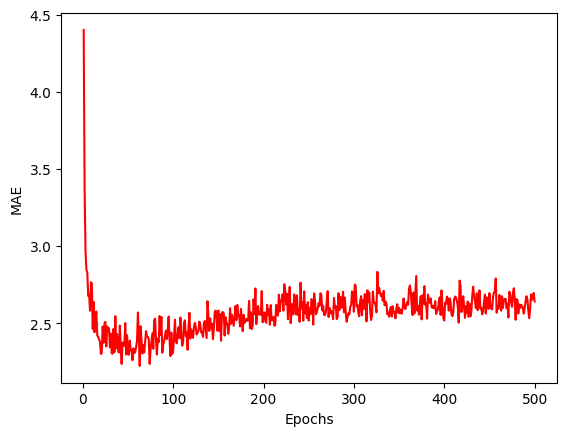

In [ ]:
# Building the history of successive mean K-fold validation scores
# Computing the average MAE over all folds for each epoch
avg_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

# Plot the average MAE history over epochs
plt.plot(range(1, num_epochs+1), avg_mae_history, color='red')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()

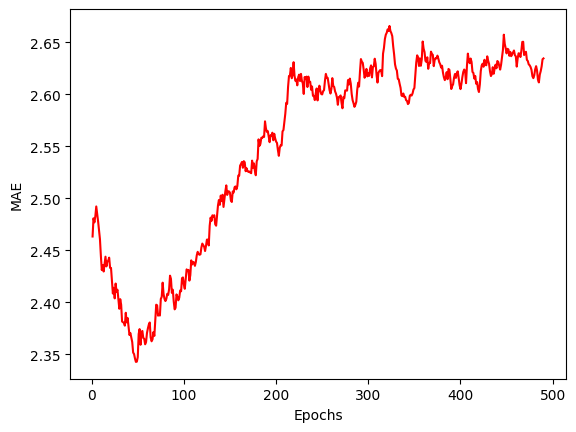

In [ ]:
# Smoothing out the MAE curve by dropping first 10 data points (which are scaled differently)
# and replacing each point with an exponential moving average of previous points.
# Function to smooth the curve
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Smoothing the MAE curve by making a 10 point moving average
smooth_mae_history = smooth_curve(avg_mae_history[10:])

# Plot the smoothed MAE curve by epochs
plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history, color='red')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()


In [ ]:
# Training the final model
# Getting a fresh compiled model
input_shape=(train_data.shape[1],)
model = build_model()
# Training the model on the full set of training data
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
# Evaluating the model
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
# Printing the MAE of the test set
print('The MAE of the test set is', test_mae_score)

4/4 [==============================] - 0s 5ms/step - loss: 19.4246 - mae: 3.0093
The MAE of the test set is 3.0093324184417725
